In [1]:
import scipy.sparse as spp
import numpy as np

In [2]:
grid_size_z = 512
domain_AR = 0.5
dx = 1.0 / grid_size_z
grid_size_r = int(domain_AR * grid_size_z)
z = np.linspace(0.5 * dx, 1 - 0.5 * dx, grid_size_z)
r = np.linspace(0.5 * dx, domain_AR - 0.5 * dx, grid_size_r)
Z, R = np.meshgrid(z, r)
R_diag = spp.diags((R ** -1).reshape(-1, ), format='csc')
A_zz = spp.diags([1, -2, 1], [-1, 0, 1], 
                shape=(grid_size_z, grid_size_z), format='csc') / (dx ** 2)
A_rr = spp.diags([1, -2, 1], [-1, 0, 1], 
                shape=(grid_size_r, grid_size_r), format='csc') / (dx ** 2)

A_zz[0, 1] *= 2.0
A_zz[-1, -2] *= 2.0
A_rr[-1, -2] *= 2.0

# A_zz[0, 0] = 2.0 / (dx ** 2)
# A_zz[0, 1] = -5.0 / (dx ** 2)
# A_zz[0, 2] = 4.0 / (dx ** 2)
# A_zz[0, 3] = -1.0 / (dx ** 2)
# A_zz[-1, 0] = 2.0 / (dx ** 2)
# A_zz[-1, 1] = -5.0 / (dx ** 2)
# A_zz[-1, 2] = 4.0 / (dx ** 2)
# A_zz[1, 3] = -1.0 / (dx ** 2)
# A_rr[-1, -1] = 1.0 / (dx ** 2)
# A_rr[-1, -2] = -2.0 / (dx ** 2)
# A_rr[-1, -3] = 1.0 / (dx ** 2)

A_r = spp.diags([-1, 1], [-1, 1], 
                shape=(grid_size_r, grid_size_r), format='csc') / (2 * dx)
A_r[-1, -2] = 0.0

# A_r[-1, -1] = 1.0 / dx
# A_r[-1, -2] = -1.0 / dx

Idz = spp.identity(grid_size_z)
Idr = spp.identity(grid_size_r)
Id1 = spp.diags(np.repeat(1.0, grid_size_r), format='csc')
Id1[0, 0] = 0.0
mask_Id = spp.kron(Id1,Idz)
Id2 = spp.diags(np.repeat(0.0, grid_size_r), format='csc')
Id2[0, 0] = 1.0
unmask_Id = spp.kron(Id2, Idz)
Id3 = spp.diags(np.repeat(1.0, grid_size_r), format="csc")
Id3[-1, -1] = 0.0

# A_r[0, 1] = 0.0
# A_rr[0, 1] *= 2.0

# Idz = spp.identity(grid_size_z)
# Idr = spp.identity(grid_size_r)
# Id1 = spp.diags(np.repeat(1.0, grid_size_r), format='csc')
# Id1[-1, -1] = 0.0
# mask_Id = spp.kron(Id1,Idz)
# Id2 = spp.diags(np.repeat(0.0, grid_size_r), format='csc')
# Id2[-1, -1] = 1.0
# unmask_Id = spp.kron(Id2, Idz)
# Id3 = spp.diags(np.repeat(1.0, grid_size_r), format="csc")
# Id3[0, -0] = 0.0

/usr/local/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [3]:
A_final = mask_Id * (spp.kron(A_rr, Idz) + spp.kron(Id3, A_zz) - R_diag * spp.kron(A_r, Idz)) + unmask_Id / (dx ** 2)
#A_final = mask_Id * (spp.kron(A_rr, Idz) + spp.kron(Id3, A_zz) + R_diag * spp.kron(A_r, Idz)) + unmask_Id / (dx ** 2)
print(A_final.toarray())
import numpy.linalg as la
# print(la.cond(A_final.toarray()))

[[ 262144.       0.       0. ...       0.       0.       0.]
 [      0.  262144.       0. ...       0.       0.       0.]
 [      0.       0.  262144. ...       0.       0.       0.]
 ...
 [      0.       0.       0. ... -524288.       0.       0.]
 [      0.       0.       0. ...       0. -524288.       0.]
 [      0.       0.       0. ...       0.       0. -524288.]]


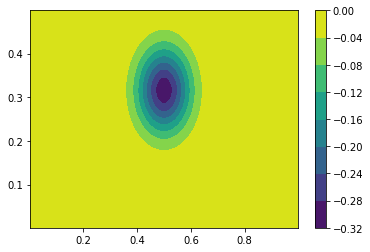

In [4]:
import scipy.sparse.linalg as sppla
import matplotlib.pyplot as plt
#vort = np.sin(np.pi * R)
vort = np.exp(-((R - 0.3) ** 2 + (Z - 0.5) ** 2) / 0.01)
plt.contourf(Z, R, -R * vort)
plt.colorbar()
b = (-R * vort).reshape(-1, )

/usr/local/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


0.034577131271362305


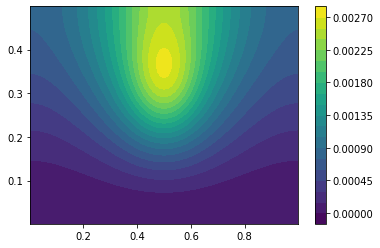

In [5]:
#A_inv = sppla.inv(A_final)
#psi = A_inv * b
# M2 = sppla.spilu(A_final)
# M = sppla.LinearOperator((grid_size_z * grid_size_r, grid_size_z * grid_size_r), M2.solve)

LU = sppla.splu(A_final)

psi = 0 * b
#psi[...], code = sppla.gmres(A_final, b, x0=psi, M=M)
import time
s = time.time()
psi[...] = LU.solve(b)
e = time.time()
print(e - s)
# A_inv = sppla.inv(A_final)
# psi = A_inv * b
#plt.contour(Z, R, psi.reshape(grid_size_r, -1), levels=50)
plt.contourf(Z, R, psi.reshape(grid_size_r, -1), levels=25)
plt.colorbar()
#print(code)

In [68]:
import numpy as np
from scipy.fftpack import fft2, ifft2
import numpy.linalg as la
grid_size_z = 512
domain_AR = 0.5
dx = 1.0 / grid_size_z
grid_size_r = int(domain_AR * grid_size_z)
CFL = 0.1
LCFL = 0.1
eps = np.finfo(float).eps


def kill_boundary_vorticity_sine_x(vorticity, X, width):
    """
    kills vorticity on the boundaries in a sine wave fashion
    in the given width in X direction
    """
    vorticity[:, :width] = np.sin(
        np.pi * (X[:, :width] - 0.5 * dx) / 2 / (width - 1) / dx
    ) * vorticity[:, (width - 1)].reshape(-1, 1)
    vorticity[:, -width:] = np.sin(
        np.pi * (1 - X[:, -width:] - 0.5 * dx) / 2 / (width - 1) / dx
    ) * vorticity[:, -width].reshape(-1, 1)


def kill_boundary_vorticity_sine_y(vorticity, Y, width):
    """
    kills vorticity on the boundaries in a sine wave fashion
    in the given width in Y direction
    """
    vorticity[:width, :] = (
        np.sin(np.pi * (Y[:width, :] - 0.5 * dx) / 2 / (width - 1) / dx)
        * vorticity[(width - 1), :]
    )
    vorticity[-width:, :] = (
        np.sin(np.pi * (1 - Y[-width:, :] - 0.5 * dx) / 2 / (width - 1) / dx)
        * vorticity[-width, :]
    )


grid_size = grid_size_z
x = np.linspace(0, 1 - dx, grid_size)
X, Y = np.meshgrid(x, x)
x_double = np.linspace(0, 2 - dx, 2 * grid_size)
X_double, Y_double = np.meshgrid(x_double, x_double)
GF = (
    np.log(
        np.sqrt(
            np.minimum(X_double, 2 - X_double) ** 2
            + np.minimum(Y_double, 2 - Y_double) ** 2
        )
        + eps
    )
    / 2
    / np.pi
)
# this term needs attention!
GF[0, 0] = (2 * np.log(dx / np.sqrt(np.pi)) - 1) / 4 / np.pi
fourier_GF = fft2(GF)

mirror_source = np.zeros((grid_size, grid_size))
mirror_old_psi = np.zeros((grid_size, grid_size))
mirror_psi = np.zeros((grid_size, grid_size))
mirror_dpsi_dr = np.zeros((grid_size, grid_size))


def poisson_solve_unb(src):
    """
    solves Poisson equation in 2D del^2(psi) = src on domain (0, 1)
    for unbounded domain using Greens function convolution and
    domain doubling trick (Hockney and Eastwood)
    """
    src_double = np.zeros((2 * grid_size, 2 * grid_size))
    src_double[:grid_size, :grid_size] = src
    psi = ifft2(fft2(src_double) * fourier_GF)
    return psi[:grid_size, :grid_size] * dx * dx

def pseudo_poisson_solve_unb(psi, vorticity, R, Z, iter_tol=1e-5):
    """
    solves axisymmetric pseudo Poisson equation in 2D
    del^2(psi)  - dpsi_dr / R = -vorticity * R on
    domain (0, 1)
    for unbounded domain using Greens function
    convolution and domain doubling trick
    (Hockney and Eastwood)
    """
    source = -vorticity * R
    mirror_psi[grid_size // 2 :, :] = psi
    mirror_psi[: grid_size // 2, :] = -np.flip(psi, axis=0)
    mirror_source[grid_size // 2 :, :] = source
    mirror_source[: grid_size // 2, :] = -np.flip(source, axis=0)
    mirror_psi[...] = np.real(poisson_solve_unb(mirror_source))
    poisson_mirror_psi = mirror_psi.copy()
    err = 1
    iter_no = 0

    while err > iter_tol:
    #while iter_no < 10:
        iter_no += 1
        mirror_old_psi[...] = mirror_psi
        mirror_dpsi_dr[1:-1, :] = (mirror_psi[2:, :] - mirror_psi[:-2, :]) / 2 / dx
        mirror_dpsi_dr[-1, :] = (
            (mirror_psi[-3, :] - 4 * mirror_psi[-2, :] + 3 * mirror_psi[-1, :]) / 2 / dx
        )
        mirror_dpsi_dr[0, :] = (
            (-mirror_psi[2, :] + 4 * mirror_psi[1, :] - 3 * mirror_psi[0, :]) / 2 / dx
        )
        mirror_dpsi_dr[grid_size // 2, :] = (
            (-mirror_psi[grid_size // 2 + 2, :] + 4 * mirror_psi[grid_size // 2 + 1, :] 
             - 3 * mirror_psi[grid_size // 2, :]) / 2 / dx
        )
        #mirror_dpsi_dr[grid_size // 2 :, :] /= R
        #kill_boundary_vorticity_sine_x(mirror_dpsi_dr[grid_size // 2 :, :], Z, 3)
        #mirror_dpsi_dr[: grid_size // 2, :] /= -np.flip(R, axis=0)
        mirror_dpsi_dr[: grid_size // 2, :] = -np.flip(
            mirror_dpsi_dr[grid_size // 2 :, :], axis=0
        )
        mirror_psi[...] = np.real(poisson_solve_unb(mirror_source + 1 * mirror_dpsi_dr))
        err = la.norm(mirror_psi - mirror_old_psi) / la.norm(mirror_psi)
        #err = la.norm(mirror_psi - mirror_old_psi) * dx
        print(err)

    psi[...] = mirror_psi[grid_size // 2 :, :]
    return mirror_psi, mirror_dpsi_dr

def pseudo_poisson_solve_iter(psi, vorticity, R, Z, iter_tol=1e-5):
    source = -vorticity * R
    old_psi = psi.copy()
    err = 1
    err2 = 1
    iter = 0
    alpha = 1.0
    
    while err2 > iter_tol:
        iter += 1
        old_psi[...] = psi.copy()
        psi[1:-1, 1:-1] = ((1.0 - alpha) * psi[1:-1, 1:-1] + 
                           alpha * 0.25 * (psi[2:,1:-1] + psi[:-2,1:-1] + psi[1:-1,2:] + psi[1:-1,:-2] 
                                                   - dx ** 2 * source[1:-1, 1:-1]
                                          -0.5 * dx * (psi[2:,1:-1] - psi[:-2,1:-1]) / R[1:-1, 1:-1]))
        #err2 = la.norm(psi - old_psi) / la.norm(psi)
        err2 = np.amax(psi - old_psi) / np.amax(psi)

        
    print(iter)
    return psi


from numba import njit, prange
@njit(parallel=True)
def pseudo_poisson_solve_iter_numba(psi, vorticity, R, Z, dx, iter_tol=1e-12):
    source = -vorticity * R
    old_psi = psi.copy()
    err = 1
    err2 = 1
    iter = 0
    alpha = 1.99
    r_grid_size = vorticity.shape[0]
    z_grid_size = vorticity.shape[1]
    
    while err2 > iter_tol:

        iter += 1
        old_psi[...] = psi.copy()
        
        for i in prange(1, z_grid_size - 1):
            for j in prange(1, r_grid_size - 1):
                psi[j, i] = ((1.0 - alpha) * psi[j, i] + 
                             alpha * 0.25 * (psi[j+1,i] + psi[j-1,i] + psi[j,i+1] + psi[j,i-1] 
                                             - dx ** 2 * source[j,i] 
                                             -0.5 * dx * (psi[j+1,i] - psi[j-1,i]) / R[j, i]))
        psi[0, :] = 0.0
        psi[-1, :] = psi[-2, :]
        psi[:, 0] = psi[:, 1]
        psi[:, -1] = psi[:, -2]
        err2 = np.amax(np.fabs(psi - old_psi)) * dx
#         err2 = np.amax(np.fabs(psi - old_psi)) / np.amax(np.fabs(psi))
        
    print(iter)
    return psi

In [69]:
# z = np.linspace(0 + dx / 2, 1 - dx / 2, grid_size_z)
# r = np.linspace(0 + dx / 2, domain_AR - dx / 2, grid_size_r)
# Z, R = np.meshgrid(z, r)
# vort = np.sin(2 * np.pi * R) ** 2 * np.sin(np.pi * Z)
# vort = np.exp(-((R - 0.3) ** 2 + (Z - 0.5) ** 2) / 0.01)
# psi = 0 * R
# mirror_psi, mirror_dpsi_dr = pseudo_poisson_solve_unb(psi, vort, R, Z)
# import matplotlib.pyplot as plt
# plt.contourf(Z, R, mirror_psi[grid_size //2:, :])
# plt.colorbar()
# plt.figure()
# plt.plot(z, mirror_psi[grid_size // 2, :])

1709
1.3897919654846191


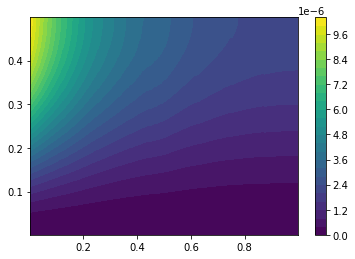

In [73]:
z = np.linspace(0 + dx / 2, 1 - dx / 2, grid_size_z)
r = np.linspace(0 + dx / 2, domain_AR - dx / 2, grid_size_r)
Z, R = np.meshgrid(z, r)
#vort = np.sin(2 * np.pi * R) ** 2 * np.sin(np.pi * Z)
vort = np.exp(-((R - 0.3) ** 2 + (Z - 0.5) ** 2) / 0.01)
psi_numba = 0 * R

import time
s = time.time()
#psi[...] = pseudo_poisson_solve_iter(psi, vort, R, Z)
psi_numba[...] = pseudo_poisson_solve_iter_numba(psi_numba, vort, R, Z, dx)
e = time.time()
print(e - s)
import matplotlib.pyplot as plt
plt.contourf(Z, R, psi_numba, levels=25)
plt.contourf(Z, R, (psi_numba - psi) / la.norm(psi), levels=25)
plt.colorbar()

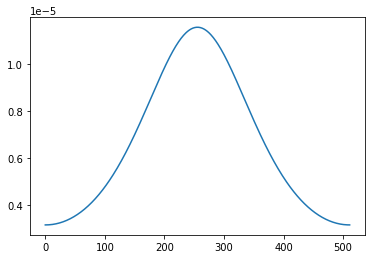

In [71]:
plt.plot(psi_numba[10, :])

In [ ]:
u_r = R / (R ** 2 + Z **2) **1.5
u_z = Z / (R ** 2 + Z **2) **1.5
plt.streamplot(Z, R, u_z, u_r)

In [ ]:
psi_ana = - Z * (R ** 2 + Z ** 2) ** -0.5
plt.contourf(Z, R, psi_ana)

In [ ]:
plt.plot(Z[0, :], u_z[0, :])